In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from textblob import TextBlob
from plotly.offline import iplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.express as px
from collections import Counter
from datetime import datetime
import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

df = pd.read_csv('Tweets.csv')
df.head()

tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason  negativereason_confidence         airline  \
0            NaN                        NaN  Virgin America   
1            NaN                     0.0000  Virgin America   
2            NaN                        NaN  Virgin America   
3     Bad Flight                     0.7033  Virgin America   
4     Can't Tell                     1.0000  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                    NaN     cairdin                 NaN              0   
1                    NaN    jnardino                 NaN              0   
2                    NaN  yvonnalynn                 NaN              0   
3                    NaN    jnardino                 NaN              0   
4                    NaN    jnardino                 NaN              0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1  @VirginAmerica plus you've added commercials t...         NaN   
2  @VirginAmerica I didn't today... Must mean I n...         NaN   
3  @VirginAmerica it's really aggressive to blast...         NaN   
4  @VirginAmerica and it's a really big bad thing...         NaN   

               tweet_created tweet_location               user_timezone  
0  2015-02-24 11:35:52 -0800            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:15:59 -0800            NaN  Pacific Time (US & Canada)  
2  2015-02-24 11:15:48 -0800      Lets Play  Central Time (US & Canada)  
3  2015-02-24 11:15:36 -0800            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:14:45 -0800            NaN  Pacific Time (US & Canada)

In [2]:
df.shape

(14640, 15)

In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
df.drop('airline_sentiment_confidence', axis=1, inplace=True)
df.drop('negativereason_confidence', axis=1, inplace=True)
df.drop('airline_sentiment_gold', axis=1, inplace=True)
df.drop('name', axis=1, inplace=True)
df.drop('negativereason_gold', axis=1, inplace=True)

def preprocess(TweetText):
    TweetText = TweetText.str.replace("(<br/>)", "")
    TweetText = TweetText.str.replace('(<a).*(>).*(</a>)', '')
    TweetText = TweetText.str.replace('(&amp)', '')
    TweetText = TweetText.str.replace('(&gt)', '')
    TweetText = TweetText.str.replace('(&lt)', '')
    TweetText = TweetText.str.replace('(\xa0)', ' ')  
    return TweetText

df['text'] = preprocess(df['text'])
df['polarity'] = df['text'].map(lambda text: TextBlob(text).sentiment.polarity)
df['text_len'] = df['text'].astype(str).apply(len)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df.head()

tweet_id airline_sentiment negativereason         airline  \
0  570306133677760513           neutral            NaN  Virgin America   
1  570301130888122368          positive            NaN  Virgin America   
2  570301083672813571           neutral            NaN  Virgin America   
3  570301031407624196          negative     Bad Flight  Virgin America   
4  570300817074462722          negative     Can't Tell  Virgin America   

   retweet_count                                               text  \
0              0                @VirginAmerica What @dhepburn said.   
1              0  @VirginAmerica plus you've added commercials t...   
2              0  @VirginAmerica I didn't today... Must mean I n...   
3              0  @VirginAmerica it's really aggressive to blast...   
4              0  @VirginAmerica and it's a really big bad thing...   

  tweet_coord              tweet_created tweet_location  \
0         NaN  2015-02-24 11:35:52 -0800            NaN   
1         NaN  2015-02-24 11:15:59 -0800            NaN   
2         NaN  2015-02-24 11:15:48 -0800      Lets Play   
3         NaN  2015-02-24 11:15:36 -0800            NaN   
4         NaN  2015-02-24 11:14:45 -0800            NaN   

                user_timezone  polarity  text_len  word_count  
0  Eastern Time (US & Canada)  0.000000        35           4  
1  Pacific Time (US & Canada)  0.000000        72           9  
2  Central Time (US & Canada) -0.390625        71          12  
3  Pacific Time (US & Canada)  0.006250       122          17  
4  Pacific Time (US & Canada) -0.350000        55          10

### 5 top tweets with the most retweet count

In [5]:
top = df[['text','retweet_count','polarity']].sort_values(by=['retweet_count'], ascending=False)
top.head(5)

text  retweet_count  \
11596  @USAirways 5 hr flight delay and a delay when ...             44   
11582  @USAirways of course never again tho . Thanks ...             32   
7132   STOP. USING.THIS.WORD. IF. YOU'RE. A. COMPANY....             31   
9999   @USAirways with this livery back in the day. h...             28   
5607   @SouthwestAir beautiful day in Seattle! http:/...             22   

       polarity  
11596       0.2  
11582       0.1  
7132        0.0  
9999        0.0  
5607        1.0

### 5 random tweets with the highest positive sentiment polarity

In [6]:
cl = df.loc[df.polarity == 1, ['text']].sample(5).values
for c in cl:
    print(c[0])

@united Great, thank you!! I'll send it now.
@VirginAmerica best customer service rep in the world! #irmafromDallas takes the cake!!!
@JetBlue thank you will do!! You guy are awesome!
@united You shouldn't page o'head that it's best to call 1-800# - on hold 26+ mins
@SouthwestAir NOR @SpiritAirlines fly to Toronto?!?!? You're killing me smalls.......


### 5 random tweets with the most neutral sentiment(zero) polarity

In [7]:
cl = df.loc[df.polarity == 0, ['text']].sample(5).values
for c in cl:
    print(c[0])

@united received my bag. I appreciate taking care of the matter and following up!
@JetBlue Not for the dates or destination I'm headed 😔
@JetBlue  please start flying to Guyana soon
@united Was just hung up on by customer service after waiting 30 min on hold...guess that vacation's not happening? Website wasn't working.
@united Thank you for the Delta transfer. Will my bags go too?


### 5 random tweets with the most negative polarity

In [8]:
cl = df.loc[df.polarity == -1, ['text']].sample(5).values
for c in cl:
    print(c[0])

@USAirways Baggage Team? Recording tells me my bag still hasn't been found. And delayed baggage link on web conveniently not working. #worst
@USAirways not happening #worstairlineever also Marie Burroughs is the worst customer service rep ever #yourairlinesucks
@USAirways never flying #USAirways again. Horrible experience, terrible customer service.
@SouthwestAir you guys should stop doing service in Denver it's horrible I get stuck here every time! I've been here almost 24hrs
@AmericanAir your gate agents at DFW gate B16 are pathetic tonight.  Terrible communication, stories changing and apathetic


In [9]:
df['polarity'].iplot(kind='hist', bins=50, xTitle='polarity', yTitle='count', linecolor='black',
                     title='Sentiment Polarity Distribution')

In [10]:
df['airline_sentiment'].iplot(kind='hist', xTitle='airline sentiment', yTitle='count', linecolor='black',
                              title='Sentiment Airline Distribution')

In [11]:
df['airline'].iplot(kind='hist', bins=50, xTitle='airline', yTitle='count', linecolor='black',
                    title='Tweets Airline Distribution')

In [12]:
df['text_len'].iplot(kind='hist', bins=100, xTitle='tweet length', yTitle='count', linecolor='black',
                     title='Tweet Text Length Distribution')

In [13]:
df['word_count'].iplot(kind='hist', bins=50, xTitle='word count', yTitle='count', linecolor='black',
                       title='Tweet Text Word Count Distribution')

In [14]:
df.groupby('tweet_location').count()['tweet_id'].sort_values(ascending=False)[:20].iplot(
    kind='bar', xTitle='Location', yTitle='Count', linecolor='black', opacity=0.8,
    title='Bar chart of Location')

In [15]:
df.groupby('user_timezone').count()['tweet_id'].sort_values(ascending=False)[:20].iplot(
    kind='bar', xTitle='Timezone', yTitle='Count', linecolor='black', opacity=0.8,
    title='Bar chart of Timezone')

In [16]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df1.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in tweet before removing stop words')

In [17]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in tweet after removing stop words')

In [18]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['text'], 20)
df3 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df3.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in tweet before removing stop words')

In [19]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['text'], 20)
df4 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df4.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in tweet after removing stop words')

In [20]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['text'], 20)
df5 = pd.DataFrame(common_words, columns = ['text', 'count'])
df5.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in tweet before removing stop words')

In [21]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['text'], 20)
df6 = pd.DataFrame(common_words, columns = ['text', 'count'])
df6.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in tweet after removing stop words')

In [22]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

positive_words = get_top_n_words(df.loc[df['airline_sentiment'] == 'positive']['text'], 20)
df7 = pd.DataFrame(positive_words, columns = ['text' , 'count'])
df7.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in tweet with positive sentiment')

In [23]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

negative_words = get_top_n_words(df.loc[df['airline_sentiment'] == 'negative']['text'], 20)
df8 = pd.DataFrame(negative_words, columns = ['text' , 'count'])
df8.groupby('text').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in tweet with negative sentiment')

In [24]:
fig = px.histogram(df, x='negativereason', title='Negative Reason Histogram')
fig.show()

In [25]:
fig = px.histogram(df, x='airline_sentiment', y='word_count', histfunc='avg', title='Average of Word Count Histogram')
fig.show()

In [26]:
df.airline.value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [27]:
x0 = df.loc[df['airline_sentiment'] == 'negative']['airline']
x1 = df.loc[df['airline_sentiment'] == 'neutral']['airline']
x2 = df.loc[df['airline_sentiment'] == 'positive']['airline']

trace0 = go.Histogram(x=x0, name = 'Negative')
trace1 = go.Histogram(x=x1, name = 'Neutral')
trace2 = go.Histogram(x=x2, name = 'Positive')

data = [trace0, trace1, trace2]
layout = go.Layout(title = "Tweet Sentiment group by Airline")
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Tweet Sentiment group by Airline")

In [28]:
y0 = df.loc[df['airline'] == 'United']['polarity']
y1 = df.loc[df['airline'] == 'US Airways']['polarity']
y2 = df.loc[df['airline'] == 'American']['polarity']
y3 = df.loc[df['airline'] == 'Southwest']['polarity']
y4 = df.loc[df['airline'] == 'Delta']['polarity']
y5 = df.loc[df['airline'] == 'Virgin America']['polarity']

trace0 = go.Box(y=y0, name = 'United', marker = dict(color = 'rgb(214, 12, 140)'))
trace1 = go.Box(y=y1, name = 'US Airways', marker = dict(color = 'rgb(0, 128, 128)'))
trace2 = go.Box(y=y2, name = 'American', marker = dict(color = 'rgb(10, 140, 208)'))
trace3 = go.Box(y=y3, name = 'Southwest', marker = dict(color = 'rgb(12, 102, 14)'))
trace4 = go.Box(y=y4, name = 'Delta', marker = dict(color = 'rgb(10, 0, 100)'))
trace5 = go.Box(y=y5, name = 'Virgin America', marker = dict(color = 'rgb(100, 0, 10)'))

data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(title = "Sentiment Polarity Boxplot of Airline")
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Airline")

In [29]:
y0 = df.loc[df['airline'] == 'United']['text_len']
y1 = df.loc[df['airline'] == 'US Airways']['text_len']
y2 = df.loc[df['airline'] == 'American']['text_len']
y3 = df.loc[df['airline'] == 'Southwest']['text_len']
y4 = df.loc[df['airline'] == 'Delta']['text_len']
y5 = df.loc[df['airline'] == 'Virgin America']['text_len']

trace0 = go.Box(y=y0, name = 'United', marker = dict(color = 'rgb(214, 12, 140)'))
trace1 = go.Box(y=y1, name = 'US Airways', marker = dict(color = 'rgb(0, 128, 128)'))
trace2 = go.Box(y=y2, name = 'American', marker = dict(color = 'rgb(10, 140, 208)'))
trace3 = go.Box(y=y3, name = 'Southwest', marker = dict(color = 'rgb(12, 102, 14)'))
trace4 = go.Box(y=y4, name = 'Delta', marker = dict(color = 'rgb(10, 0, 100)'))
trace5 = go.Box(y=y5, name = 'Virgin America', marker = dict(color = 'rgb(100, 0, 10)'))

data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(title = "Tweet Length Boxplot of Airline")
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Tweet Length Boxplot of Airline")

In [30]:
y0 = df.loc[df['airline'] == 'United']['word_count']
y1 = df.loc[df['airline'] == 'US Airways']['word_count']
y2 = df.loc[df['airline'] == 'American']['word_count']
y3 = df.loc[df['airline'] == 'Southwest']['word_count']
y4 = df.loc[df['airline'] == 'Delta']['word_count']
y5 = df.loc[df['airline'] == 'Virgin America']['word_count']

trace0 = go.Box(y=y0, name = 'United', marker = dict(color = 'rgb(214, 12, 140)'))
trace1 = go.Box(y=y1, name = 'US Airways', marker = dict(color = 'rgb(0, 128, 128)'))
trace2 = go.Box(y=y2, name = 'American', marker = dict(color = 'rgb(10, 140, 208)'))
trace3 = go.Box(y=y3, name = 'Southwest', marker = dict(color = 'rgb(12, 102, 14)'))
trace4 = go.Box(y=y4, name = 'Delta', marker = dict(color = 'rgb(10, 0, 100)'))
trace5 = go.Box(y=y5, name = 'Virgin America', marker = dict(color = 'rgb(100, 0, 10)'))

data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(title = "Tweet Text Word Count Boxplot of Airline")
fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Tweet Text Word Count Boxplot of Airline")

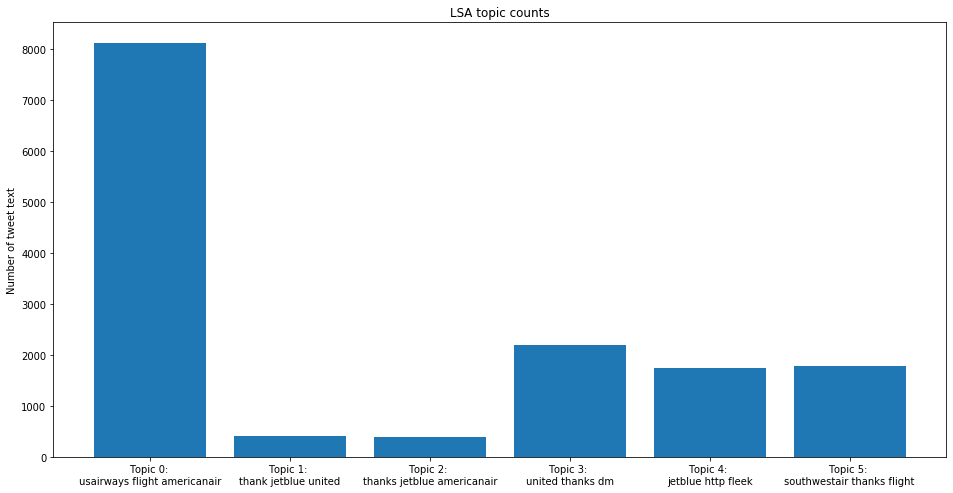

In [31]:
reindexed_data = df['text']
tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True, smooth_idf=True)
reindexed_data = reindexed_data.values
document_term_matrix = tfidf_vectorizer.fit_transform(reindexed_data)
n_topics = 6
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(document_term_matrix)

def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)
    
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

def get_top_n_words(n, keys, document_term_matrix, tfidf_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = tfidf_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words
    
top_3_words = get_top_n_words(3, lsa_keys, document_term_matrix, tfidf_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts)
ax.set_xticks(lsa_categories)
ax.set_xticklabels(labels)
ax.set_ylabel('Number of tweet text')
ax.set_title('LSA topic counts')
plt.show()

In [32]:
mapa = df[['text','airline','airline_sentiment','tweet_coord']].dropna(subset=['tweet_coord'])
mapa['tweet_coord'] = mapa['tweet_coord'].map(lambda c: c.replace(']','').replace('[','').split(','))
mapa['latitude'] = mapa['tweet_coord'].apply(lambda x: float(x[0]))
mapa['longitude'] = mapa['tweet_coord'].apply(lambda x: float(x[1]))
mapa.head()

text         airline  \
21  @VirginAmerica I love this graphic. http://t.c...  Virgin America   
28  @VirginAmerica amazing to me that we can't get...  Virgin America   
29  @VirginAmerica LAX to EWR - Middle seat on a r...  Virgin America   
32  @VirginAmerica help, left expensive headphones...  Virgin America   
34  @VirginAmerica this is great news!  America co...  Virgin America   

   airline_sentiment                    tweet_coord   latitude   longitude  
21          positive   [40.74804263,  -73.99295302]  40.748043  -73.992953  
28          negative     [42.361016,  -71.02000488]  42.361016  -71.020005  
29           neutral   [33.94540417,  -118.4062472]  33.945404 -118.406247  
32          negative  [33.94209449,  -118.40410103]  33.942094 -118.404101  
34          positive     [33.2145038,  -96.9321504]  33.214504  -96.932150

In [33]:
mapbox_access_token = 'pk.eyJ1IjoiamF2b2VyaWEiLCJhIjoiY2szMnZrMm1oMG02ODNoczN4c2xna2NtZyJ9.0MZhJe42nZdeubgK6OOMSQ'
px.set_mapbox_access_token(mapbox_access_token)
fig = px.scatter_mapbox(mapa, lat="latitude", lon="longitude", color="airline", hover_name="airline_sentiment", zoom=1)
fig.show()

In [34]:
fig = px.scatter_mapbox(mapa, lat="latitude", lon="longitude", animation_frame="airline_sentiment", hover_name="text", zoom=1)
fig.show()

In [35]:
date = df[['polarity','airline','airline_sentiment','tweet_created']]
date['tweet_created'] = date['tweet_created'].map(lambda c: datetime.strptime(c, '%Y-%m-%d %H:%M:%S %z'))
date['day'] = date['tweet_created'].apply(lambda x: x.day)
date['hour'] = date['tweet_created'].apply(lambda x: x.hour)
date = date[date['day'] != 16]
date.head()

polarity         airline airline_sentiment             tweet_created  day  \
0  0.000000  Virgin America           neutral 2015-02-24 11:35:52-08:00   24   
1  0.000000  Virgin America          positive 2015-02-24 11:15:59-08:00   24   
2 -0.390625  Virgin America           neutral 2015-02-24 11:15:48-08:00   24   
3  0.006250  Virgin America          negative 2015-02-24 11:15:36-08:00   24   
4 -0.350000  Virgin America          negative 2015-02-24 11:14:45-08:00   24   

   hour  
0    11  
1    11  
2    11  
3    11  
4    11

In [36]:
fig = px.histogram(date, x="polarity", color="airline")
fig.show()

In [37]:
date1 = date.sort_values(by=['day','airline_sentiment'], ascending=True)
fig = px.histogram(date1, x="polarity", color="airline", animation_frame="day")
fig.show()

In [38]:
date2 = date.sort_values(by=['hour','airline_sentiment'], ascending=True)
fig = px.histogram(date2, x="polarity", color="airline", animation_frame="hour")
fig.show()

In [39]:
date1 = date.sort_values(by=['day','airline_sentiment'], ascending=True)
fig = px.histogram(date1, x="airline_sentiment", color="airline", animation_frame="day")
fig.show()

In [40]:
date2 = date.sort_values(by=['hour','airline_sentiment'], ascending=True)
fig = px.histogram(date2, x="airline_sentiment", color="airline", animation_frame="hour")
fig.show()